# 0.0. IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime

from scipy import stats as ss
from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from tabulate import tabulate

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

    
warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values  # Substituindo .as_matrix() por .values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DESCRICAO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename

df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
748232,853,5,2013-08-30,9748,1070,1,1,0,1,a,a,14040.0,NaN,NaN,0,NaN,NaN,NaN


In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
#competition_distance

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


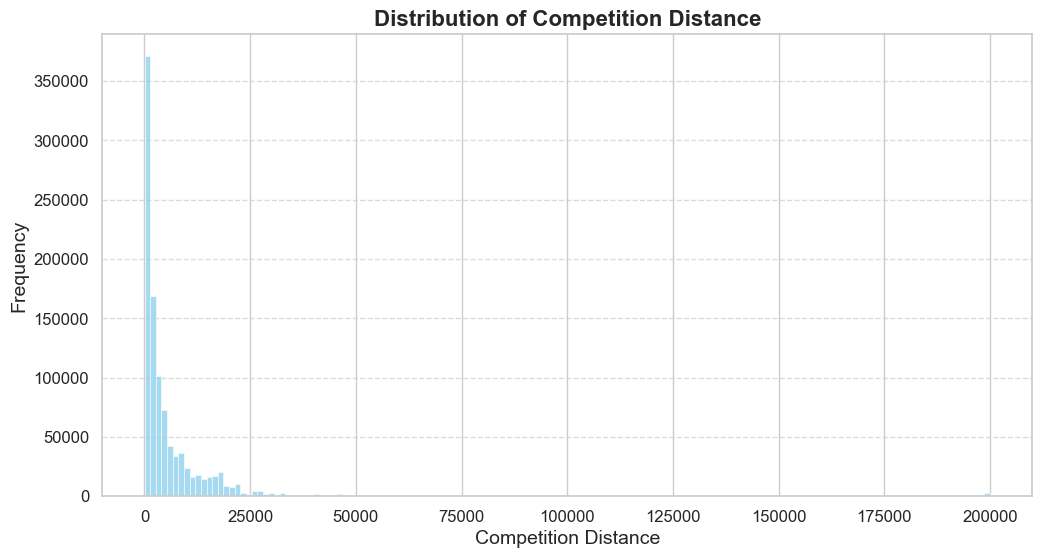

In [16]:
# Configurar estilo
sns.set_theme(style="whitegrid")

# Gráfico de distribuição com `sns.histplot`
plt.figure(figsize=(12, 6))  # Ajuste do tamanho da figura
sns.histplot(df1['competition_distance'], kde=False, bins=150, color='skyblue')
plt.title('Distribution of Competition Distance', fontsize=16, fontweight='bold')
plt.xlabel('Competition Distance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 1.7.2. Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

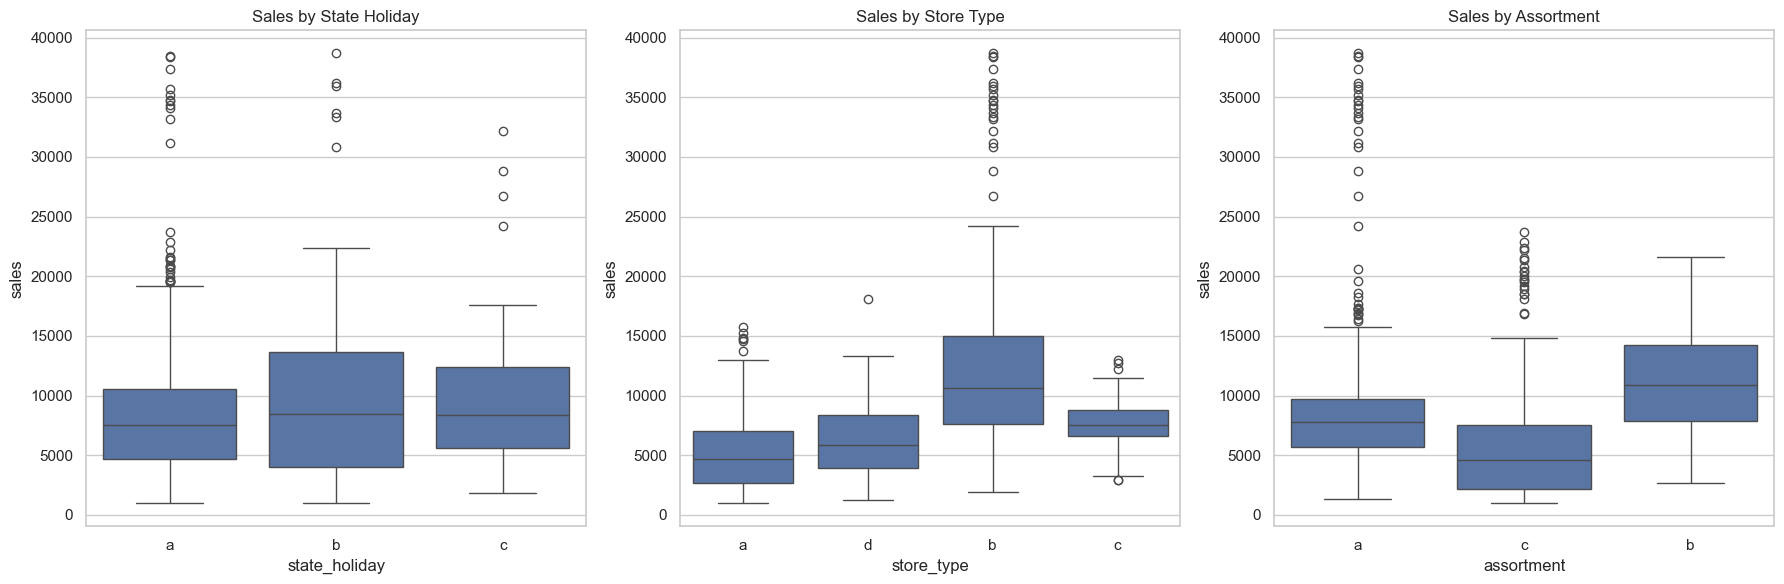

In [18]:
# Filtrando o DataFrame
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Ajustando o tamanho da figura
plt.figure(figsize=(18, 6))  # Aumenta a largura para 18 e a altura para 6

# Gráfico 1
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)
plt.title('Sales by State Holiday')

# Gráfico 2
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)
plt.title('Sales by Store Type')

# Gráfico 3
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)
plt.title('Sales by Assortment')

# Mostrando os gráficos
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# 2.0. FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

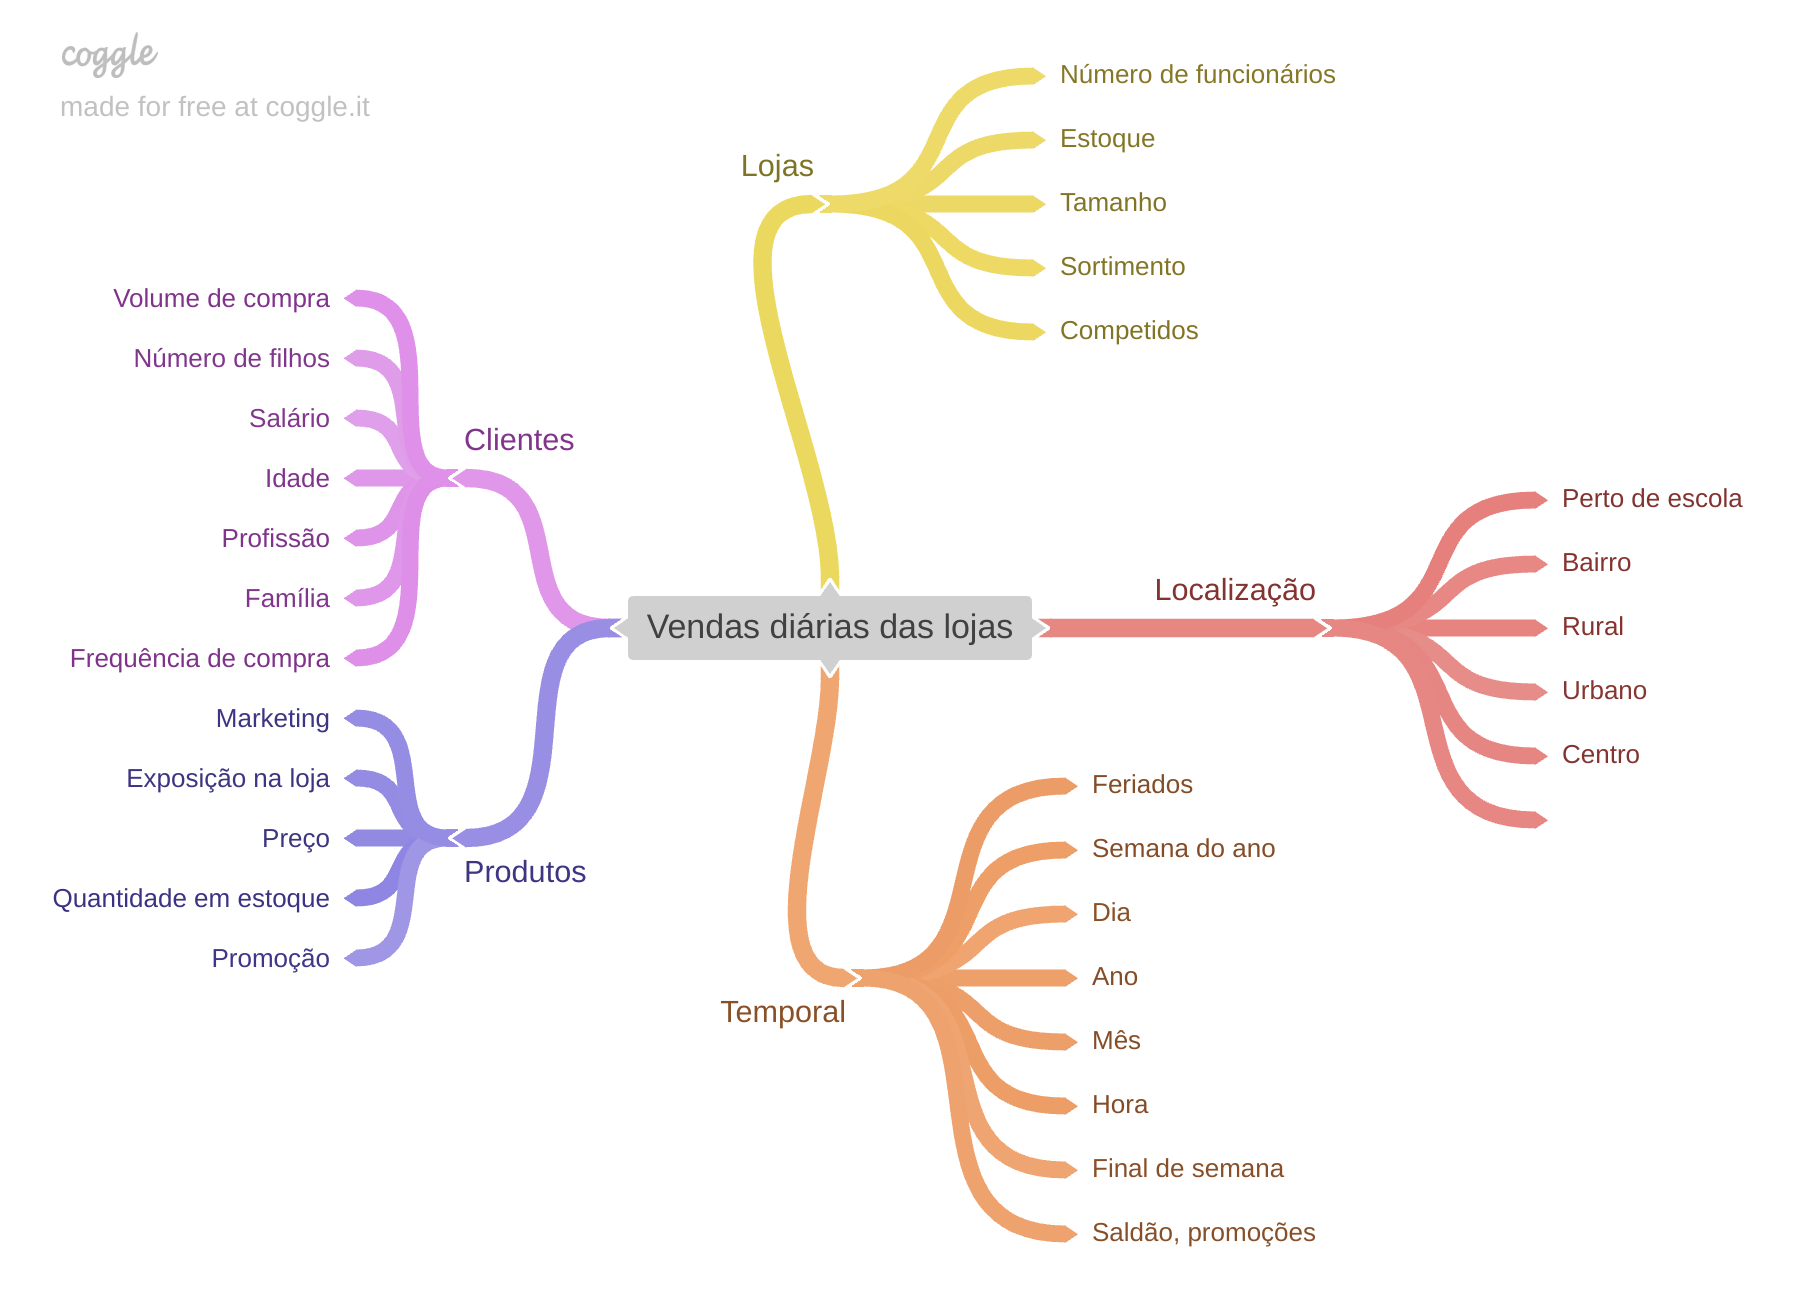

In [20]:
Image('img/MindMapHypothesis.png')

## 2.2. Criação das Hipóteses

### 2.1.1. Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month 
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0. FILTRAGEM DE VARIAVEIS

In [22]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. ANALISE EXPLORATORIA DOS DADOS

In [25]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

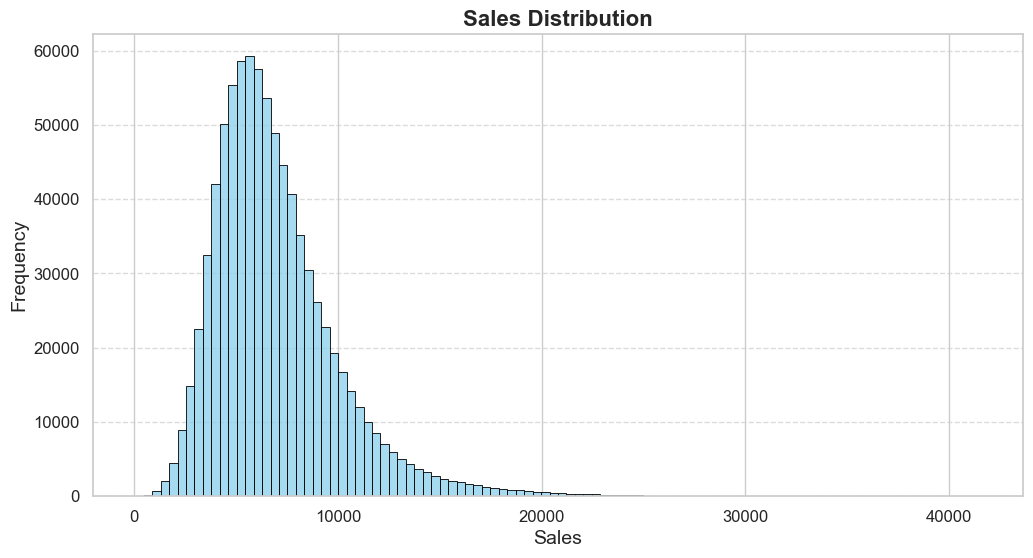

In [26]:
# Configurar estilo do gráfico
sns.set_theme(style="whitegrid")

# Gráfico de distribuição usando sns.histplot
plt.figure(figsize=(12, 6))  # Ajuste do tamanho do gráfico
sns.histplot(df4['sales'], kde=False, bins=100, color='skyblue', edgecolor='black')
plt.title('Sales Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Sales', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 4.1.2. Numerical Variable

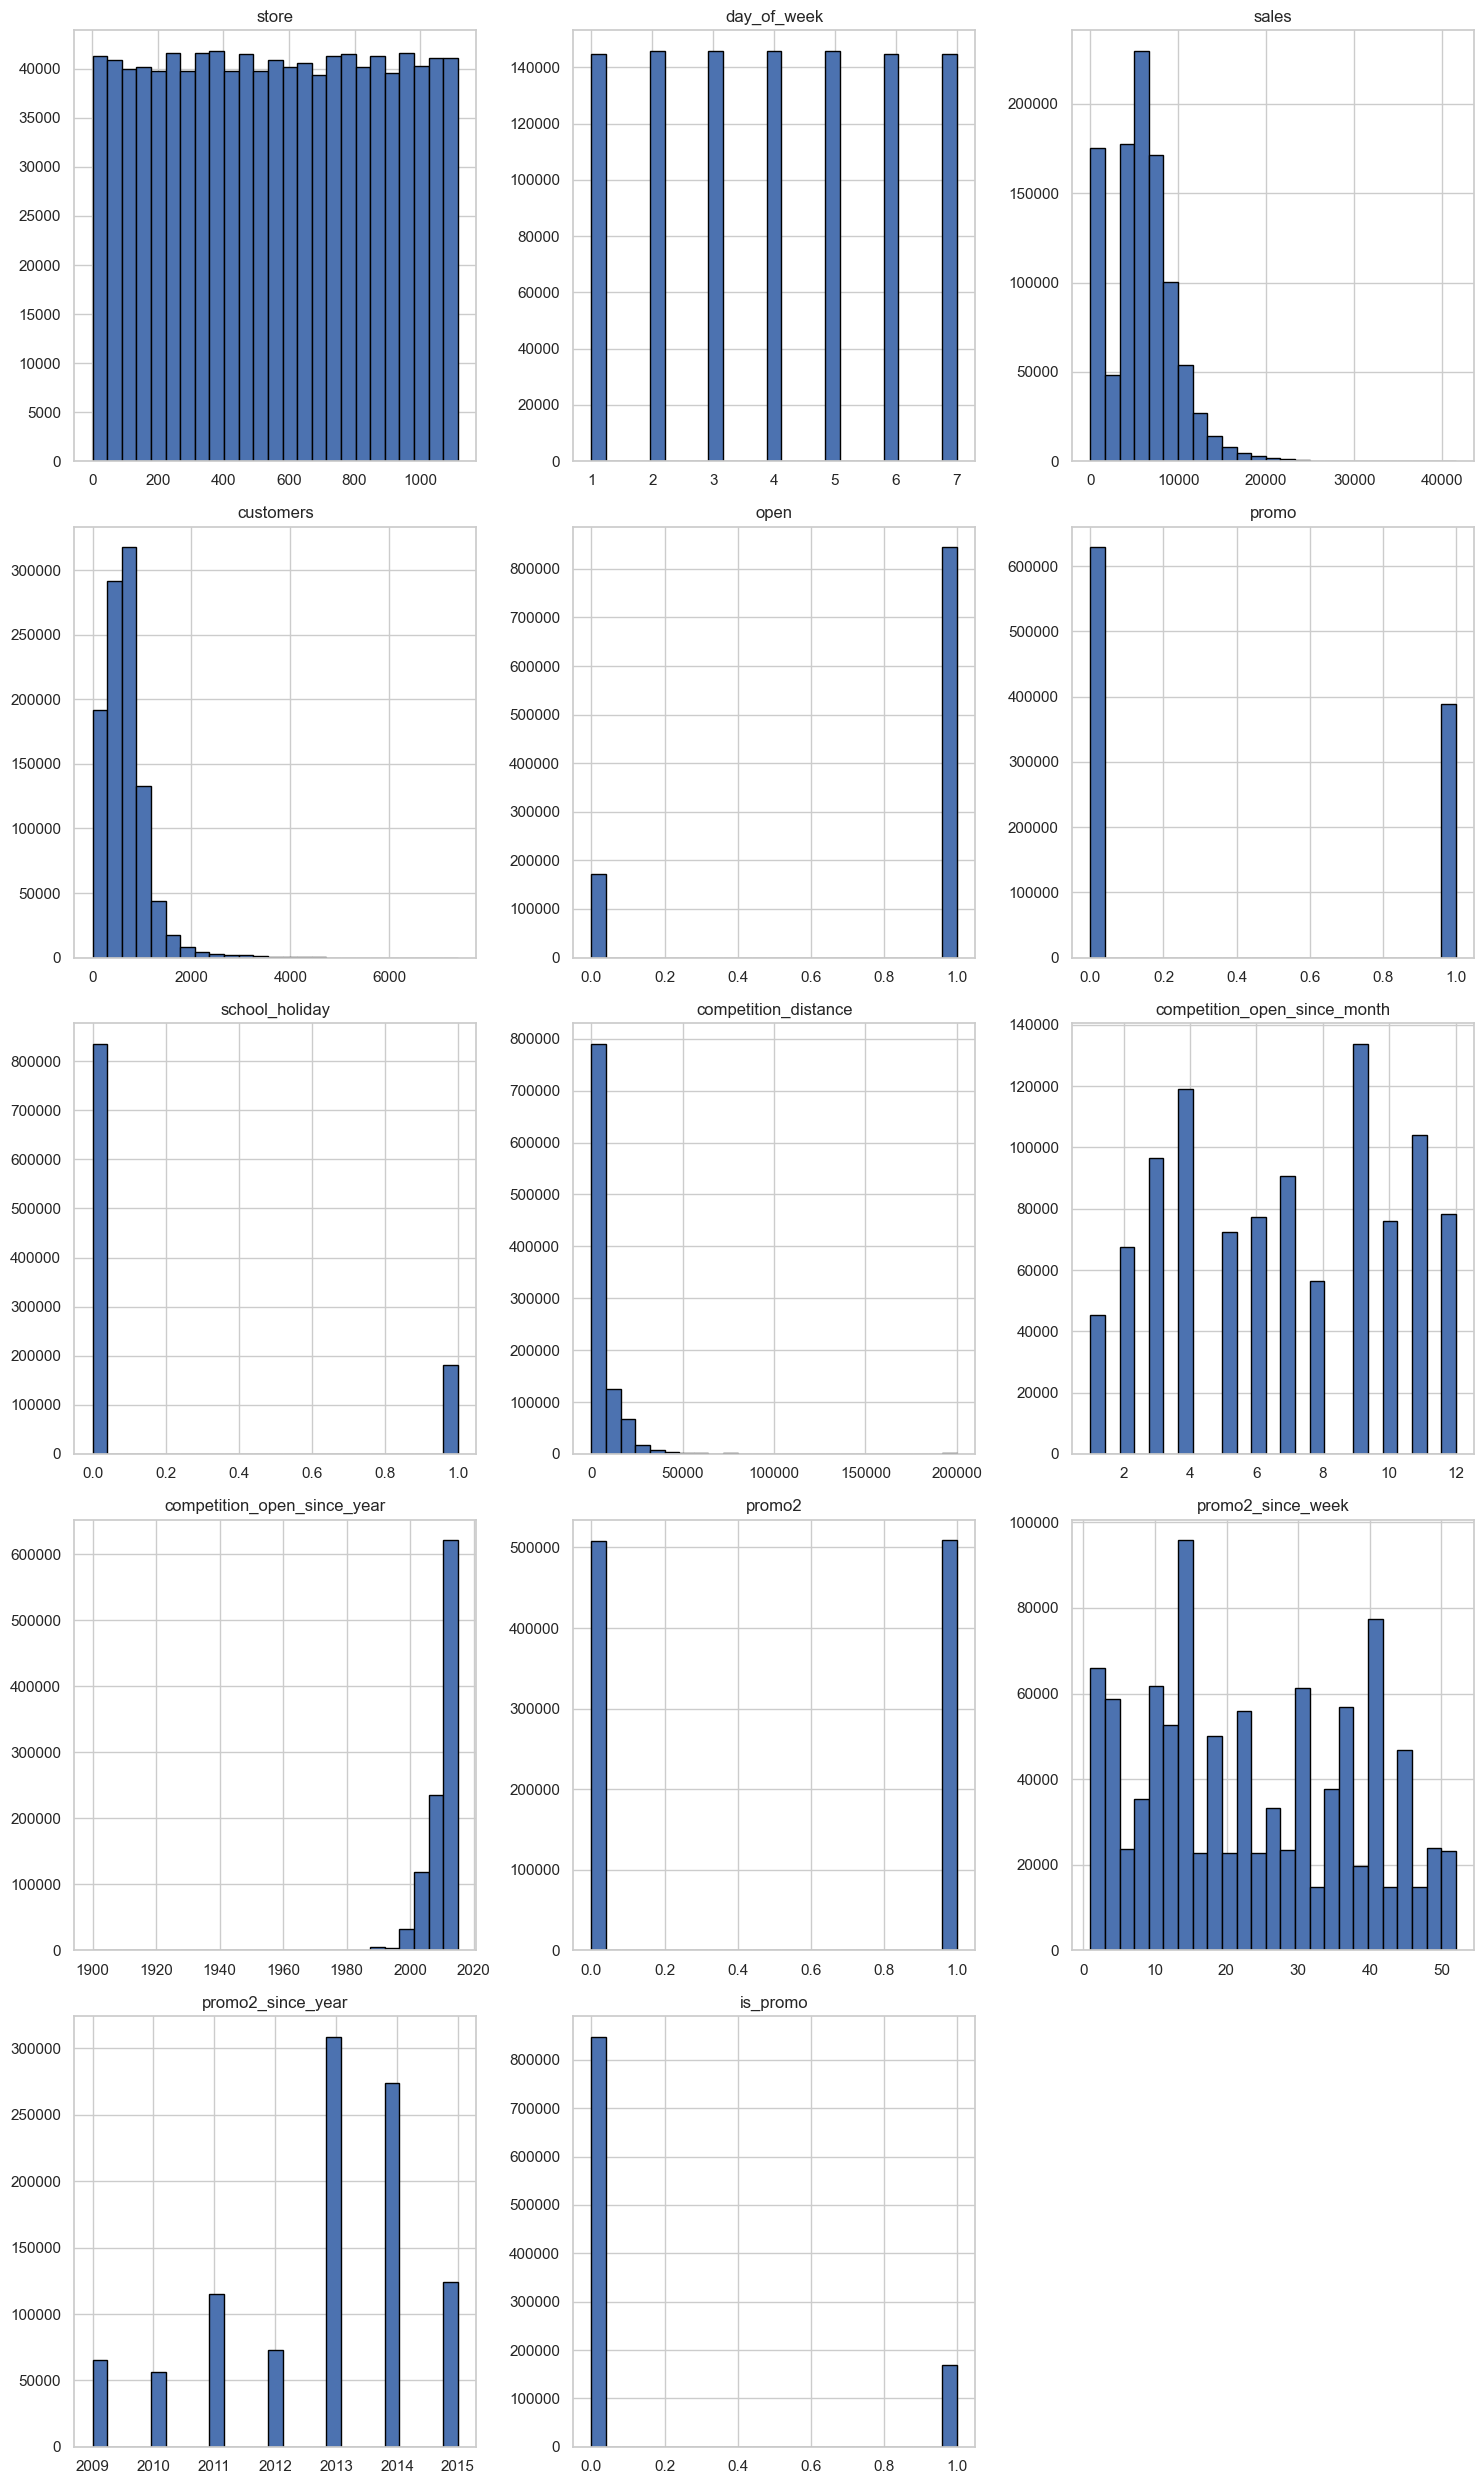

In [27]:
# Número de colunas numéricas
num_cols = num_attributes.shape[1]

# Calcula o número de linhas necessário
cols = 3  # Número fixo de colunas por linha
rows = math.ceil(num_cols / cols)  # Calcula o número de linhas

# Cria a figura com o layout ajustado
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Aumenta a altura proporcional às linhas
axes = axes.flatten()  # Achata os eixos para iterar facilmente

# Plota cada coluna em seu respectivo eixo
for i, column in enumerate(num_attributes.columns):
    num_attributes[column].hist(bins=25, ax=axes[i], edgecolor='black')
    axes[i].set_title(column, fontsize=12)

# Remove gráficos vazios, caso o layout tenha mais eixos do que necessário
for i in range(len(num_attributes.columns), len(axes)):
    fig.delaxes(axes[i])

# Ajusta o layout
plt.tight_layout()
plt.show()

### 4.1.3. Categorical Variable

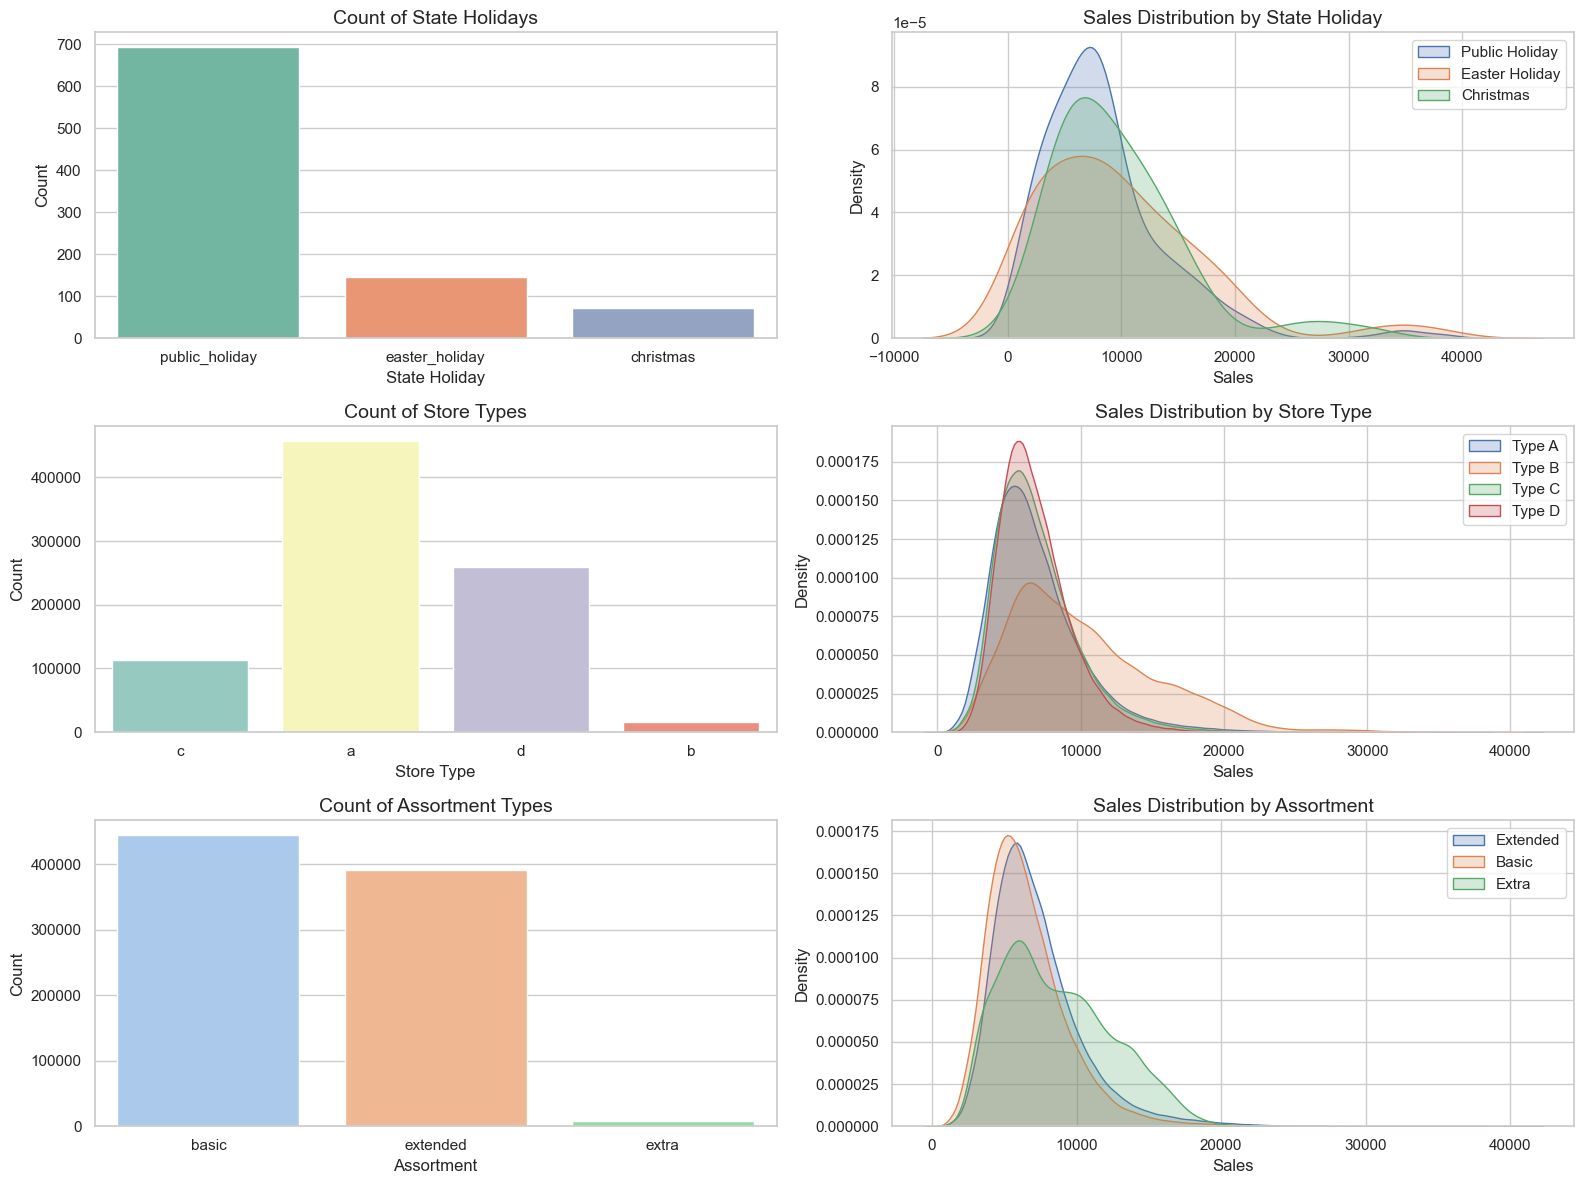

In [28]:
# Ajustando o tamanho da figura
plt.figure(figsize=(16, 12))  # Largura de 16 e altura de 12

# Gráfico 1: Contagem de state_holiday (excluindo 'regular_day')
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a, palette='Set2')
plt.title('Count of State Holidays', fontsize=14)
plt.xlabel('State Holiday', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Gráfico 2: Distribuição de vendas por tipo de state_holiday
plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='Public Holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='Easter Holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='Christmas', shade=True)
plt.title('Sales Distribution by State Holiday', fontsize=14)
plt.xlabel('Sales', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()

# Gráfico 3: Contagem de store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4, palette='Set3')
plt.title('Count of Store Types', fontsize=14)
plt.xlabel('Store Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Gráfico 4: Distribuição de vendas por tipo de store_type
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='Type A', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='Type B', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='Type C', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='Type D', shade=True)
plt.title('Sales Distribution by Store Type', fontsize=14)
plt.xlabel('Sales', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()

# Gráfico 5: Contagem de assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4, palette='pastel')
plt.title('Count of Assortment Types', fontsize=14)
plt.xlabel('Assortment', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Gráfico 6: Distribuição de vendas por tipo de assortment
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='Extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='Basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='Extra', shade=True)
plt.title('Sales Distribution by Assortment', fontsize=14)
plt.xlabel('Sales', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()

# Ajustando o layout
plt.tight_layout()
plt.show()

## 4.2. Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

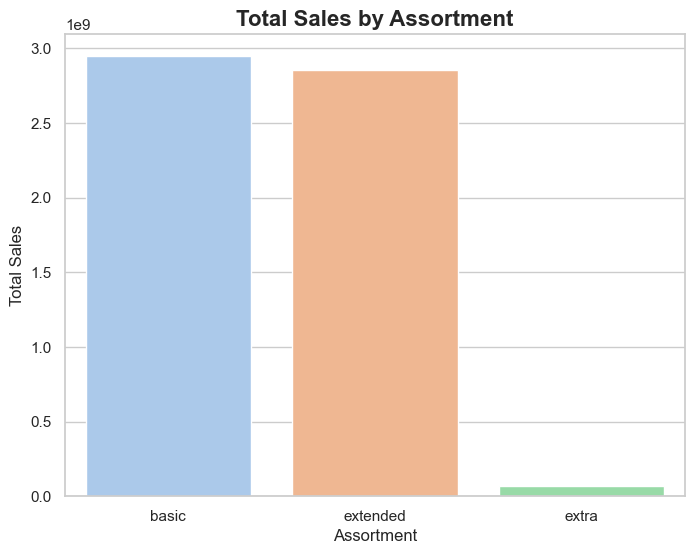

<Figure size 1200x800 with 0 Axes>

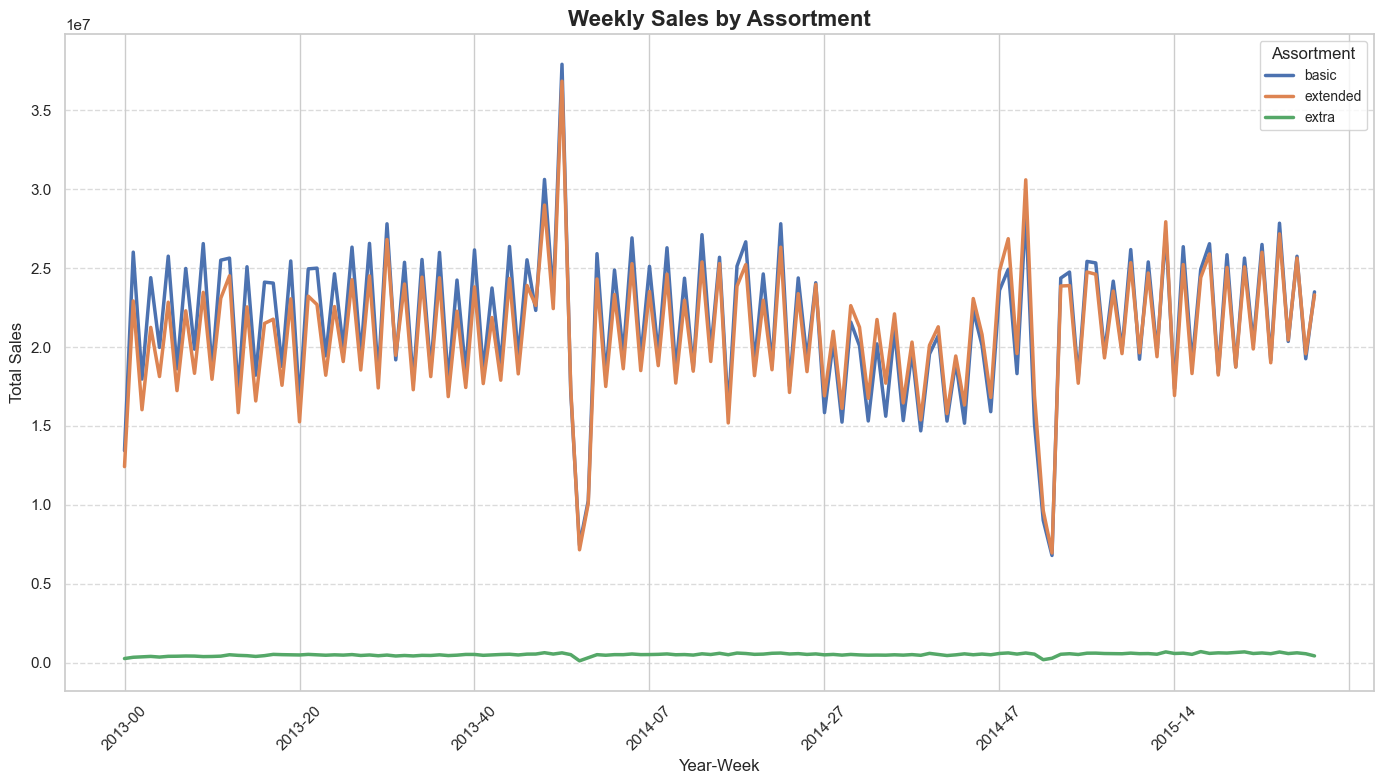

<Figure size 1200x600 with 0 Axes>

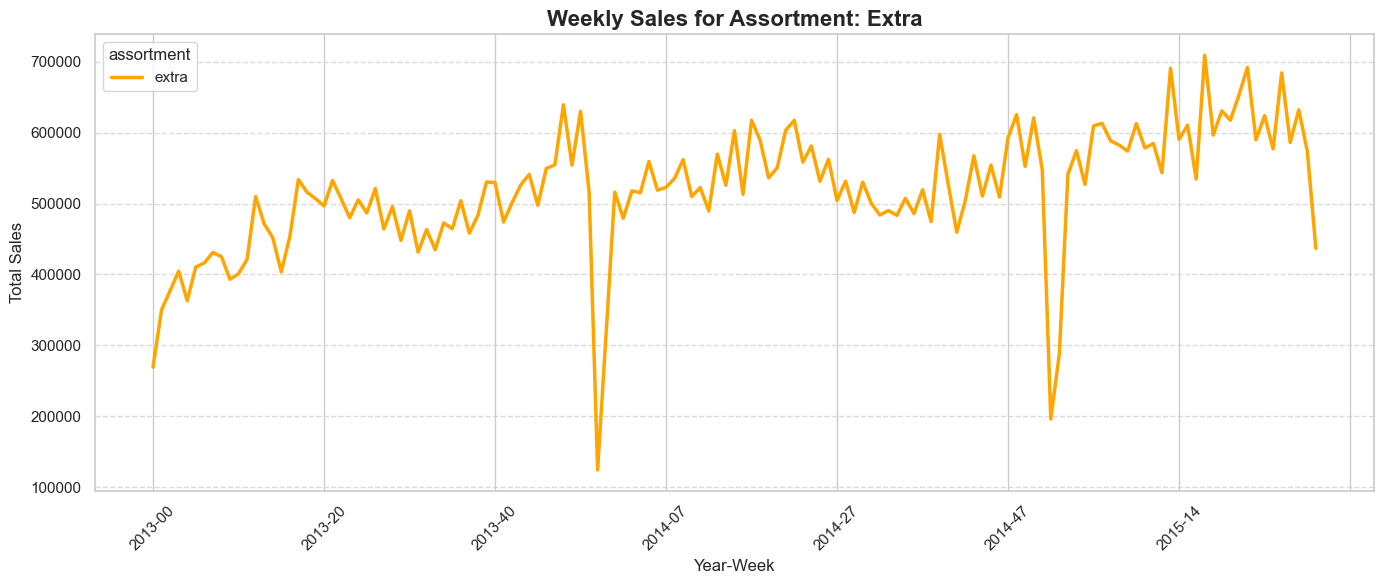

In [29]:
# Configurando tema
sns.set_theme(style="whitegrid")

# Barplot de Sales por Assortment
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='assortment', y='sales', data=aux1, palette='pastel')
plt.title('Total Sales by Assortment', fontsize=16, fontweight='bold')
plt.xlabel('Assortment', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.show()

# Gráfico de linhas - Sales por Assortment ao longo do tempo
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

plt.figure(figsize=(12, 8))
sales_pivot = aux2.pivot(index='year_week', columns='assortment', values='sales')
sales_pivot.plot(figsize=(14, 8), linewidth=2.5)
plt.title('Weekly Sales by Assortment', fontsize=16, fontweight='bold')
plt.xlabel('Year-Week', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Assortment', fontsize=10, title_fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de linhas - Sales para Assortment "extra"
aux3 = aux2[aux2['assortment'] == 'extra']

plt.figure(figsize=(12, 6))
extra_pivot = aux3.pivot(index='year_week', columns='assortment', values='sales')
extra_pivot.plot(figsize=(14, 6), color='orange', linewidth=2.5)
plt.title('Weekly Sales for Assortment: Extra', fontsize=16, fontweight='bold')
plt.xlabel('Year-Week', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

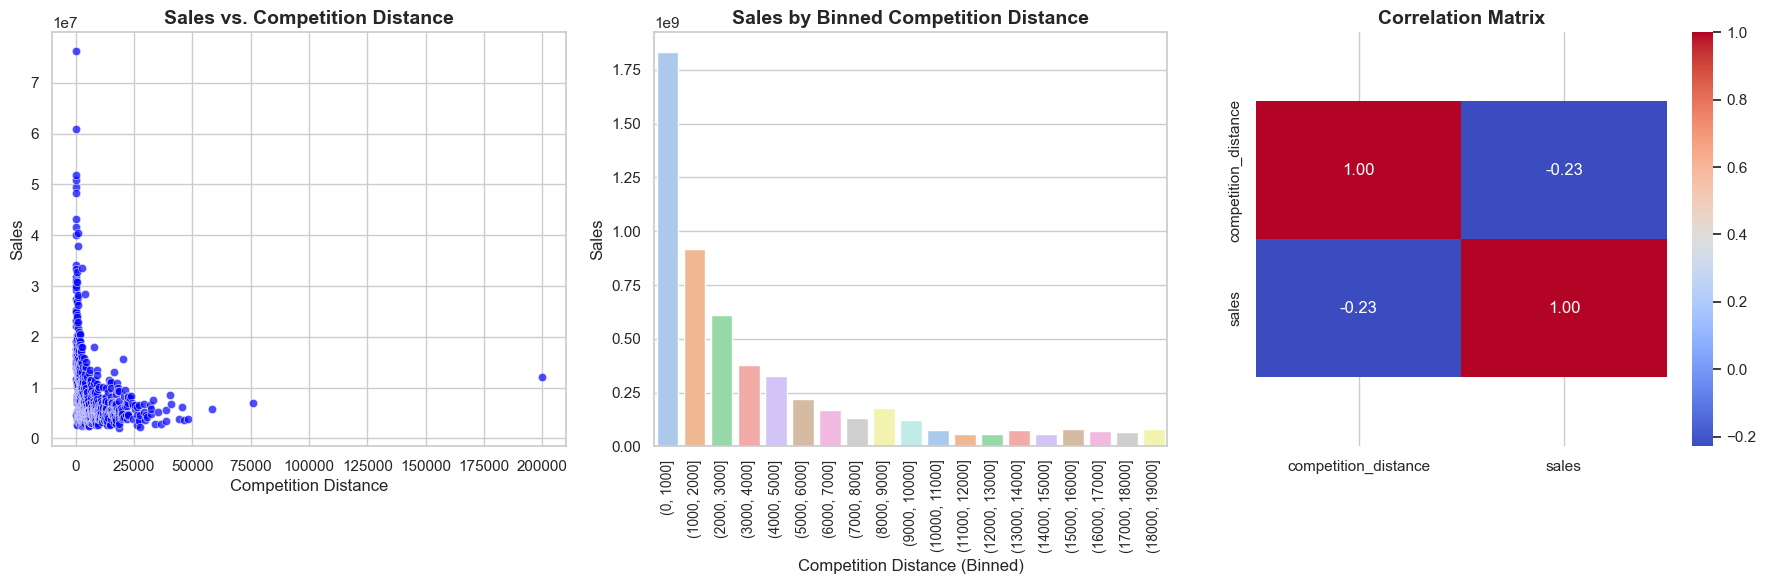

In [30]:
# Configurações gerais de estilo
sns.set_theme(style="whitegrid")

# Preparando os dados
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Ajustando o tamanho da figura
plt.figure(figsize=(18, 6))

# Gráfico 1: Scatterplot
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1, alpha=0.7, color='blue')
plt.title('Sales vs. Competition Distance', fontsize=14, fontweight='bold')
plt.xlabel('Competition Distance', fontsize=12)
plt.ylabel('Sales', fontsize=12)

# Gráfico 2: Barplot (distância em bins)
plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, palette='pastel')
plt.title('Sales by Binned Competition Distance', fontsize=14, fontweight='bold')
plt.xlabel('Competition Distance (Binned)', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# Gráfico 3: Heatmap (Correlação)
plt.subplot(1, 3, 3)
corr_matrix = aux1[['competition_distance', 'sales']].corr(method='pearson')
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
bottom, top = heatmap.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)

# Ajustando o layout
plt.tight_layout()
plt.show()

### H3. Lojas com competidores à mais tempo deveriam vendem mais.

**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

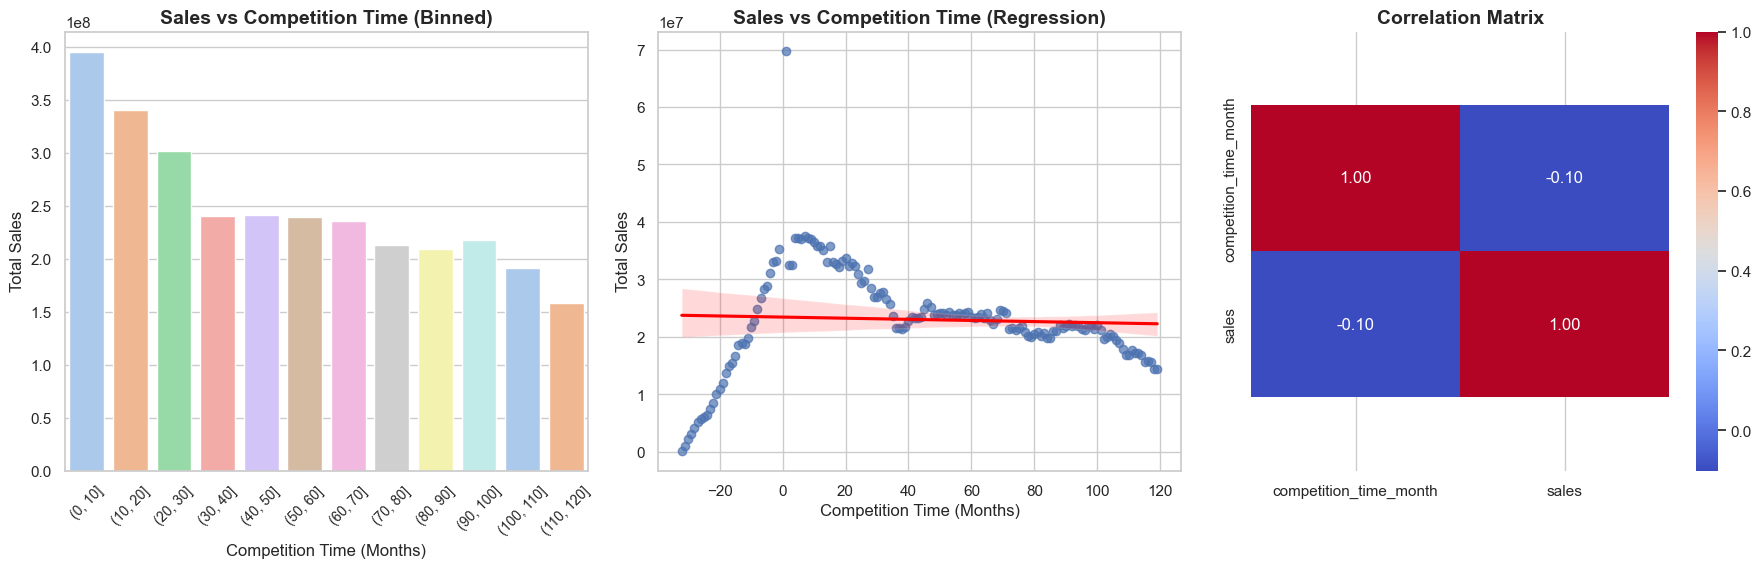

In [31]:
# Ajustando tamanho da figura
plt.figure(figsize=(18, 6))

# Gráfico 1: Barplot com Bins - Competition Time vs Sales
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# Criando intervalos de bins para agrupar os dados
bins = list(range(0, 130, 10))  # Intervalos de 10 meses
aux1['competition_time_binned'] = pd.cut(aux1['competition_time_month'], bins=bins)
aux2 = aux1.groupby('competition_time_binned').sum().reset_index()

sns.barplot(x='competition_time_binned', y='sales', data=aux2, palette='pastel')
plt.title('Sales vs Competition Time (Binned)', fontsize=14, fontweight='bold')
plt.xlabel('Competition Time (Months)', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Gráfico 2: Regplot - Relação Competition Time vs Sales
plt.subplot(1, 3, 2)
aux3 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.regplot(x='competition_time_month', y='sales', data=aux3, scatter_kws={'alpha': 0.7}, line_kws={'color': 'red'})
plt.title('Sales vs Competition Time (Regression)', fontsize=14, fontweight='bold')
plt.xlabel('Competition Time (Months)', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

# Gráfico 3: Heatmap - Correlação entre variáveis
plt.subplot(1, 3, 3)
corr_matrix = aux1[['competition_time_month', 'sales']].corr(method='pearson')
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
bottom, top = heatmap.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)

# Ajustando o layout para evitar sobreposição
plt.tight_layout()
plt.show()

### H5. Lojas com mais dias de promoção deveriam vender mais.

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [32]:
 df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


<Figure size 1200x600 with 0 Axes>

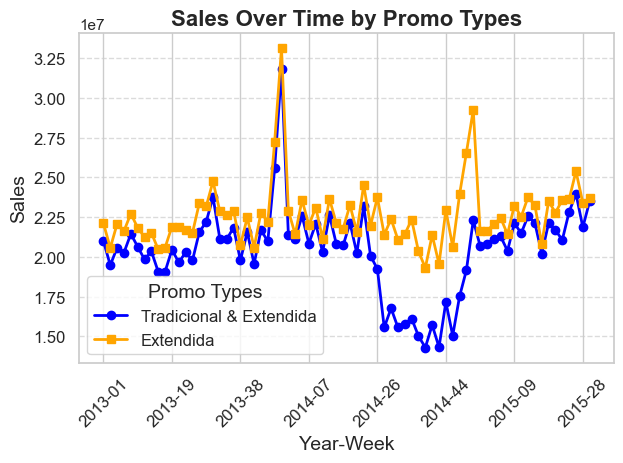

In [33]:
# Filtragem e agregação
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# Plotagem
plt.figure(figsize=(12, 6))  # Tamanho da figura
ax = aux1.plot(x='year_week', y='sales', label='Tradicional & Extendida', ax=None, color='blue', linewidth=2, marker='o')
aux2.plot(x='year_week', y='sales', label='Extendida', ax=ax, color='orange', linewidth=2, marker='s')

# Melhorias visuais
plt.title('Sales Over Time by Promo Types', fontsize=16, fontweight='bold')
plt.xlabel('Year-Week', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Promo Types', fontsize=12, title_fontsize=14)
plt.tight_layout()  # Ajusta o layout para evitar cortes
plt.show()

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

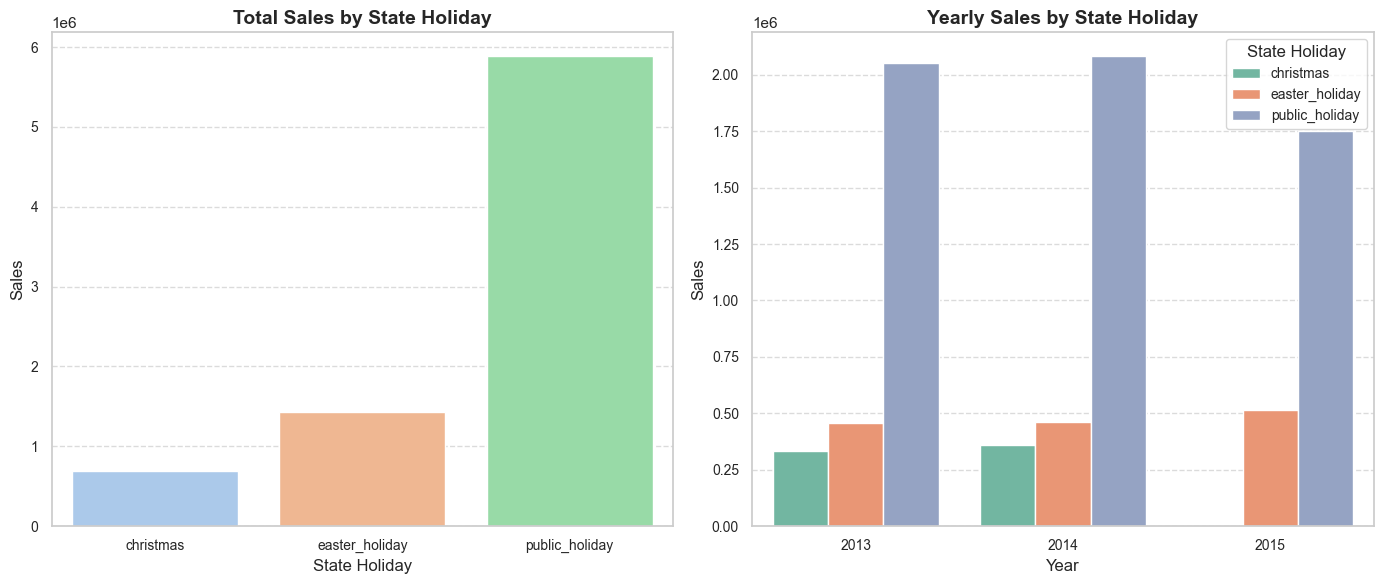

In [34]:
# Filtrando os dados
aux = df4[df4['state_holiday'] != 'regular_day']

# Configurando o tamanho da figura
plt.figure(figsize=(14, 6))

# Gráfico 1: Vendas por tipo de feriado
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, palette='pastel')
plt.title('Total Sales by State Holiday', fontsize=14, fontweight='bold')
plt.xlabel('State Holiday', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 2: Vendas por ano e tipo de feriado
plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2, palette='Set2')
plt.title('Yearly Sales by State Holiday', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='State Holiday', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustando o layout
plt.tight_layout()
plt.show()

### H8. Lojas deveriam vender mais ao longo dos anos.

**FALSA** Lojas vendem menos ao longo dos anos

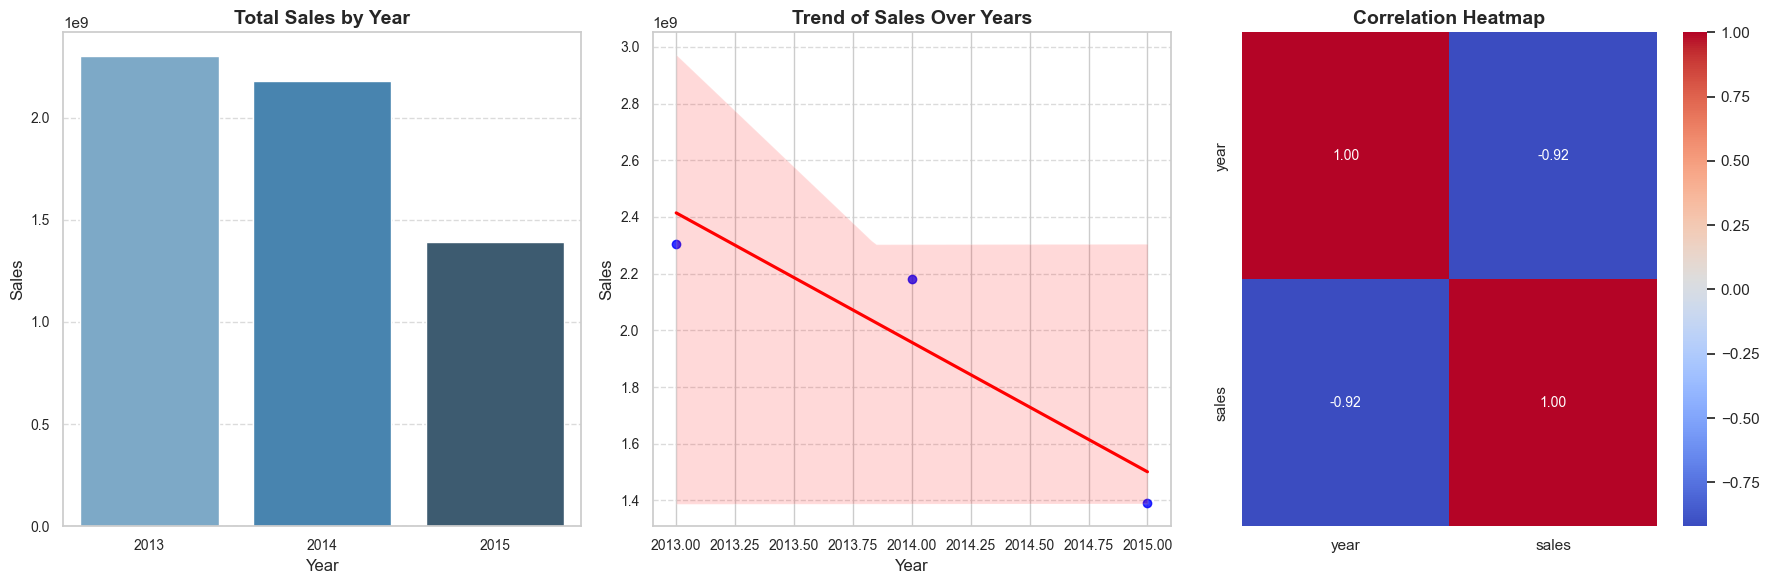

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agregando as vendas por ano
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# Configurando o tamanho da figura
plt.figure(figsize=(18, 6))

# Gráfico 1: Barplot de vendas por ano
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1, palette='Blues_d')
plt.title('Total Sales by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 2: Regressão de vendas por ano
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Trend of Sales Over Years', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 3: Heatmap de correlação
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', cbar=True, fmt='.2f', annot_kws={'fontsize': 10})
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')

# Ajustando o layout
plt.tight_layout()
plt.show()

### H9. Lojas deveriam vender mais no segundo semestre do ano.

**FALSA** Lojas vendem menos no segundo semestre do ano

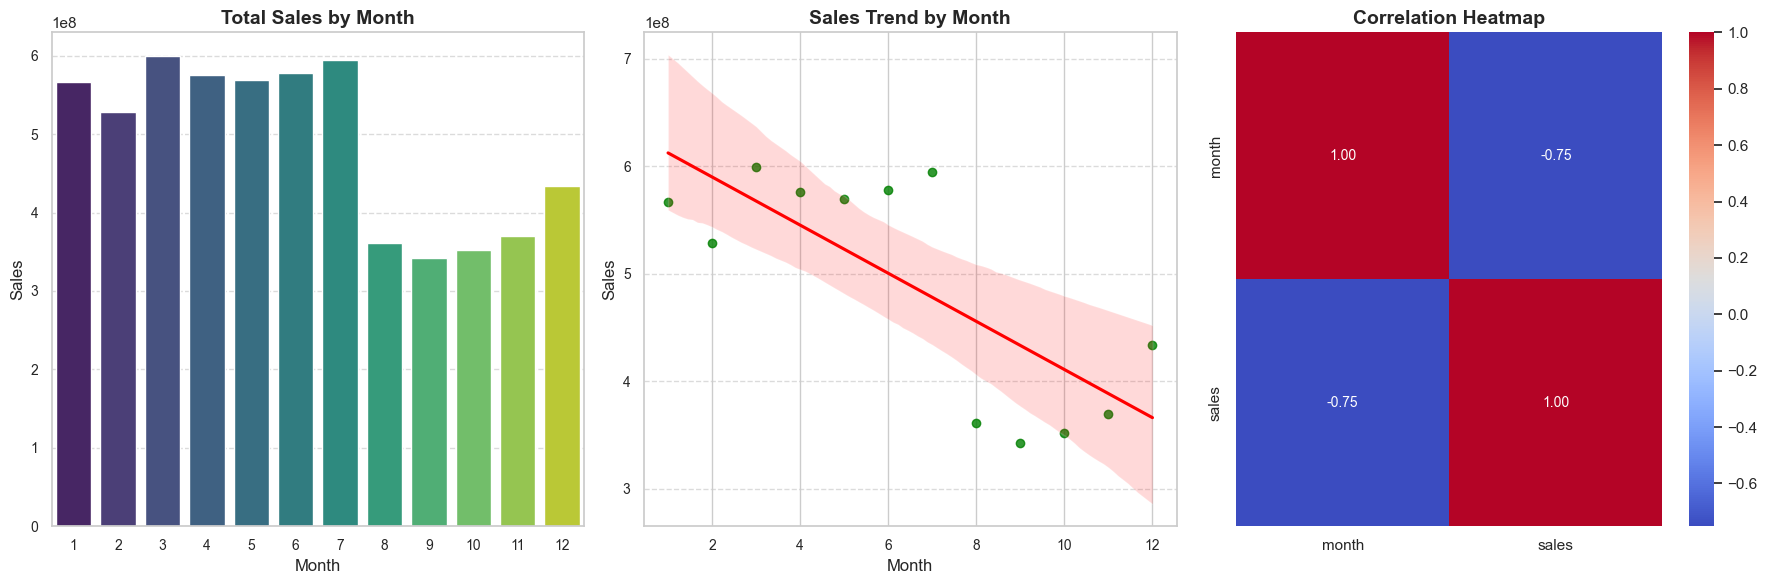

In [36]:
# Agregando as vendas por mês
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Configurando o tamanho da figura
plt.figure(figsize=(18, 6))

# Gráfico 1: Barplot de vendas por mês
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1, palette='viridis')
plt.title('Total Sales by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 2: Regressão de vendas por mês
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1, scatter_kws={'color': 'green'}, line_kws={'color': 'red'})
plt.title('Sales Trend by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 3: Heatmap de correlação
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', cbar=True, fmt='.2f', annot_kws={'fontsize': 10})
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')

# Ajustando o layout
plt.tight_layout()
plt.show()

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
 
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

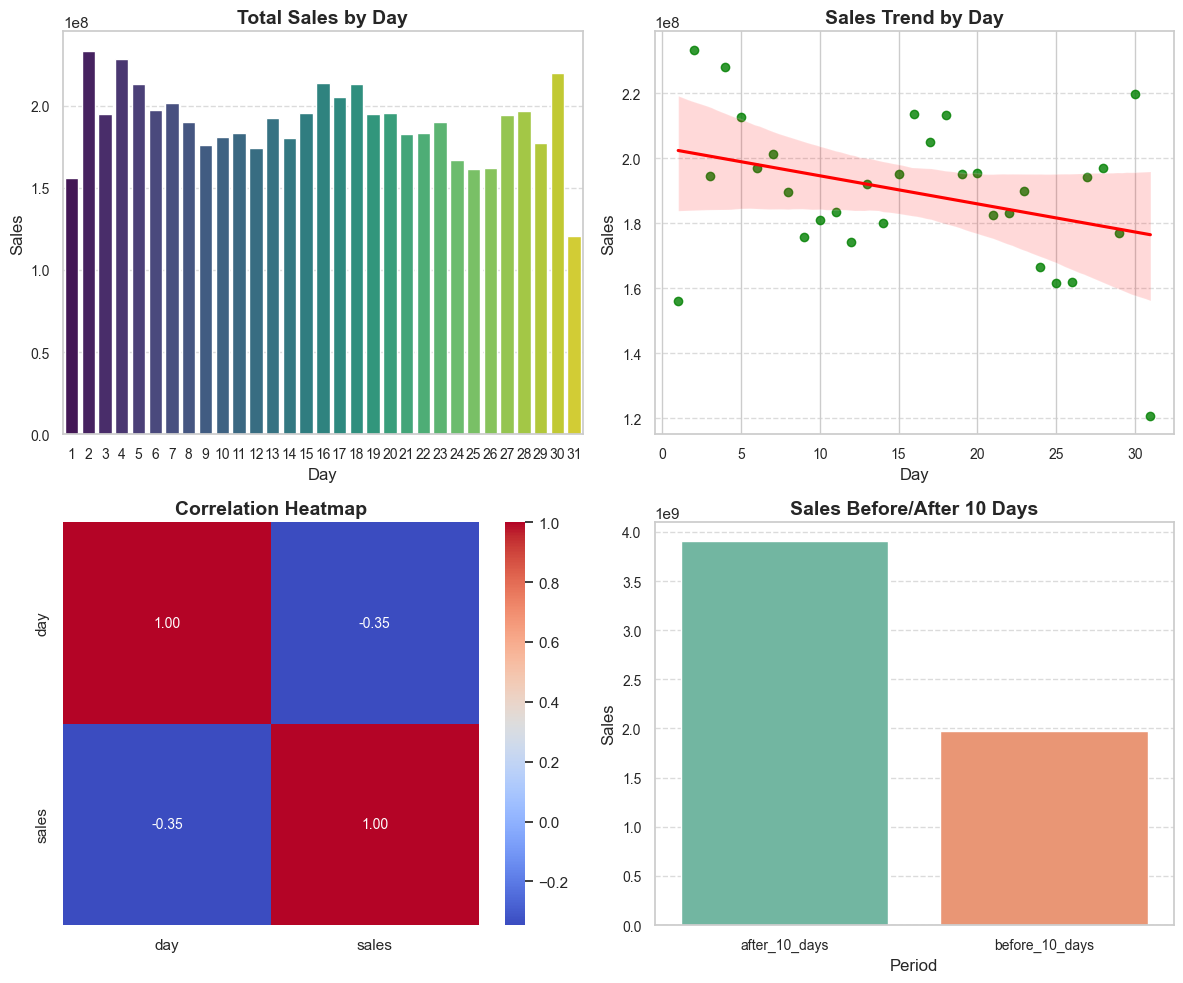

In [37]:
# Preparando os dados
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

# Criando DataFrame para o heatmap (removendo 'before_after')
corr_data = aux1[['day', 'sales']]

# Configurando o tamanho da figura
plt.figure(figsize=(12, 10))

# Gráfico 1: Barplot de vendas por dia
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1, palette='viridis')
plt.title('Total Sales by Day', fontsize=14, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 2: Regressão de vendas por dia
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1, scatter_kws={'color': 'green'}, line_kws={'color': 'red'})
plt.title('Sales Trend by Day', fontsize=14, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 3: Heatmap de correlação
plt.subplot(2, 2, 3)
sns.heatmap(corr_data.corr(method='pearson'), annot=True, cmap='coolwarm', cbar=True, fmt='.2f', annot_kws={'fontsize': 10})
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')

# Gráfico 4: Vendas antes e depois dos 10 primeiros dias
plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2, palette='Set2')
plt.title('Sales Before/After 10 Days', fontsize=14, fontweight='bold')
plt.xlabel('Period', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustando o layout
plt.tight_layout()
plt.show()

### H11. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** Lojas vendem menos nos final de semana

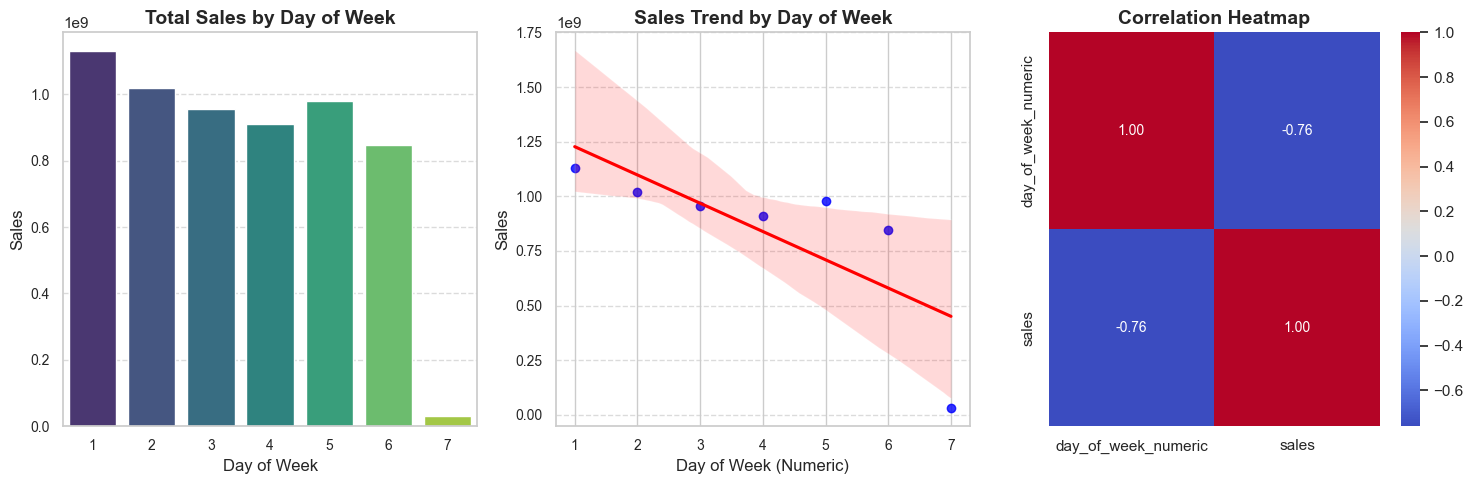

In [38]:
# Criando o DataFrame de agrupamento
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Certifique-se de que 'day_of_week' seja categórico e ordenado corretamente (opcional)
# aux1['day_of_week'] = pd.Categorical(aux1['day_of_week'], categories=['Monday', 'Tuesday', ..., 'Sunday'], ordered=True)

# Transformar 'day_of_week' em numérico para regressão e correlação
aux1['day_of_week_numeric'] = aux1['day_of_week'].factorize()[0]

# Ajustar o tamanho do gráfico
plt.figure(figsize=(15, 5))

# Gráfico 1: Barplot de vendas por dia da semana
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1, palette='viridis')
plt.title('Total Sales by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 2: Regressão de vendas por dia da semana
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week_numeric', y='sales', data=aux1, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Sales Trend by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week (Numeric)', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(ticks=aux1['day_of_week_numeric'], labels=aux1['day_of_week'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 3: Heatmap de correlação
plt.subplot(1, 3, 3)
sns.heatmap(aux1[['day_of_week_numeric', 'sales']].corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'fontsize': 10})
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')

# Ajustar layout
plt.tight_layout()
plt.show()

### H12. Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

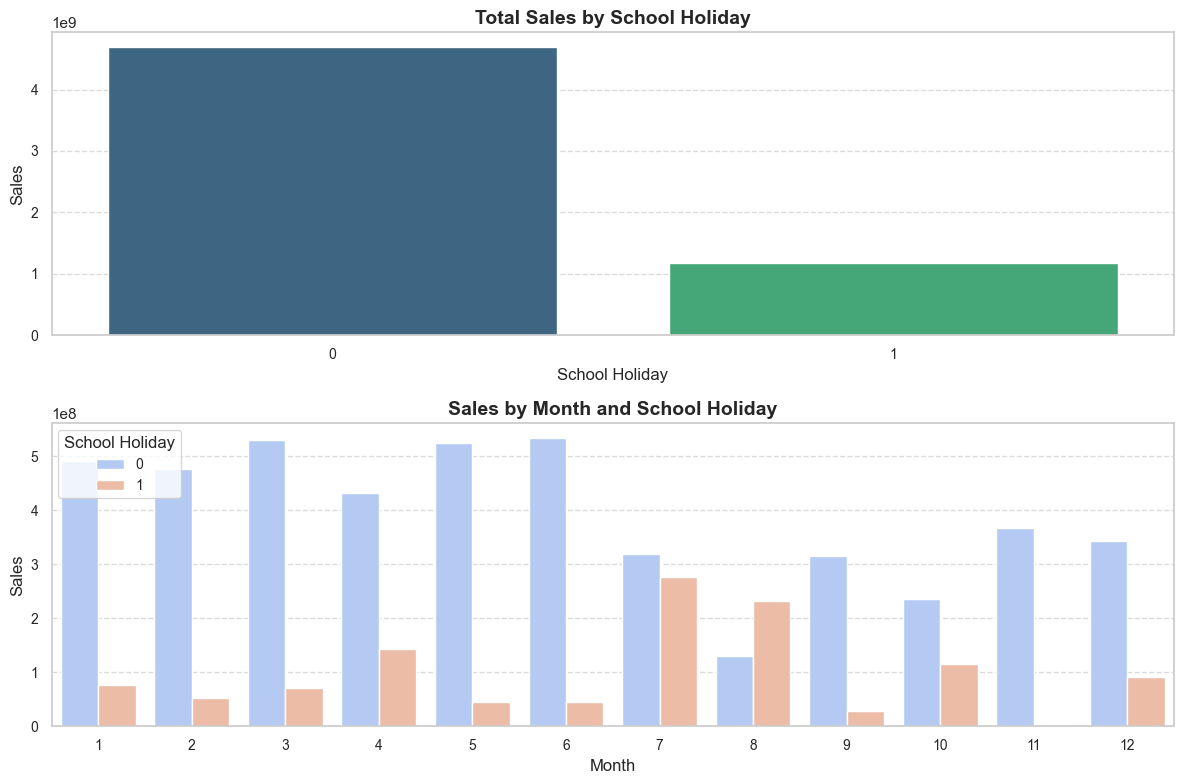

In [39]:
# Criando o DataFrame de agrupamento para 'school_holiday' e 'sales'
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

# Ajustando o tamanho do gráfico
plt.figure(figsize=(12, 8))

# Gráfico 1: Barplot de vendas por tipo de feriado escolar
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1, palette='viridis')
plt.title('Total Sales by School Holiday', fontsize=14, fontweight='bold')
plt.xlabel('School Holiday', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Criando o DataFrame de agrupamento para 'month', 'school_holiday' e 'sales'
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

# Gráfico 2: Vendas por mês e feriado escolar
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2, palette='coolwarm')
plt.title('Sales by Month and School Holiday', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='School Holiday', loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustando layout para evitar sobreposição
plt.tight_layout()
plt.show()

### 4.2.1. Resumo das Hipoteses

In [40]:
tab = [
    ['Hipoteses', 'Conclusao', 'Relevancia'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H6', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Media'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Baixa'],
]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Analise Bivariada

### 4.3.1. Numerical Attributes

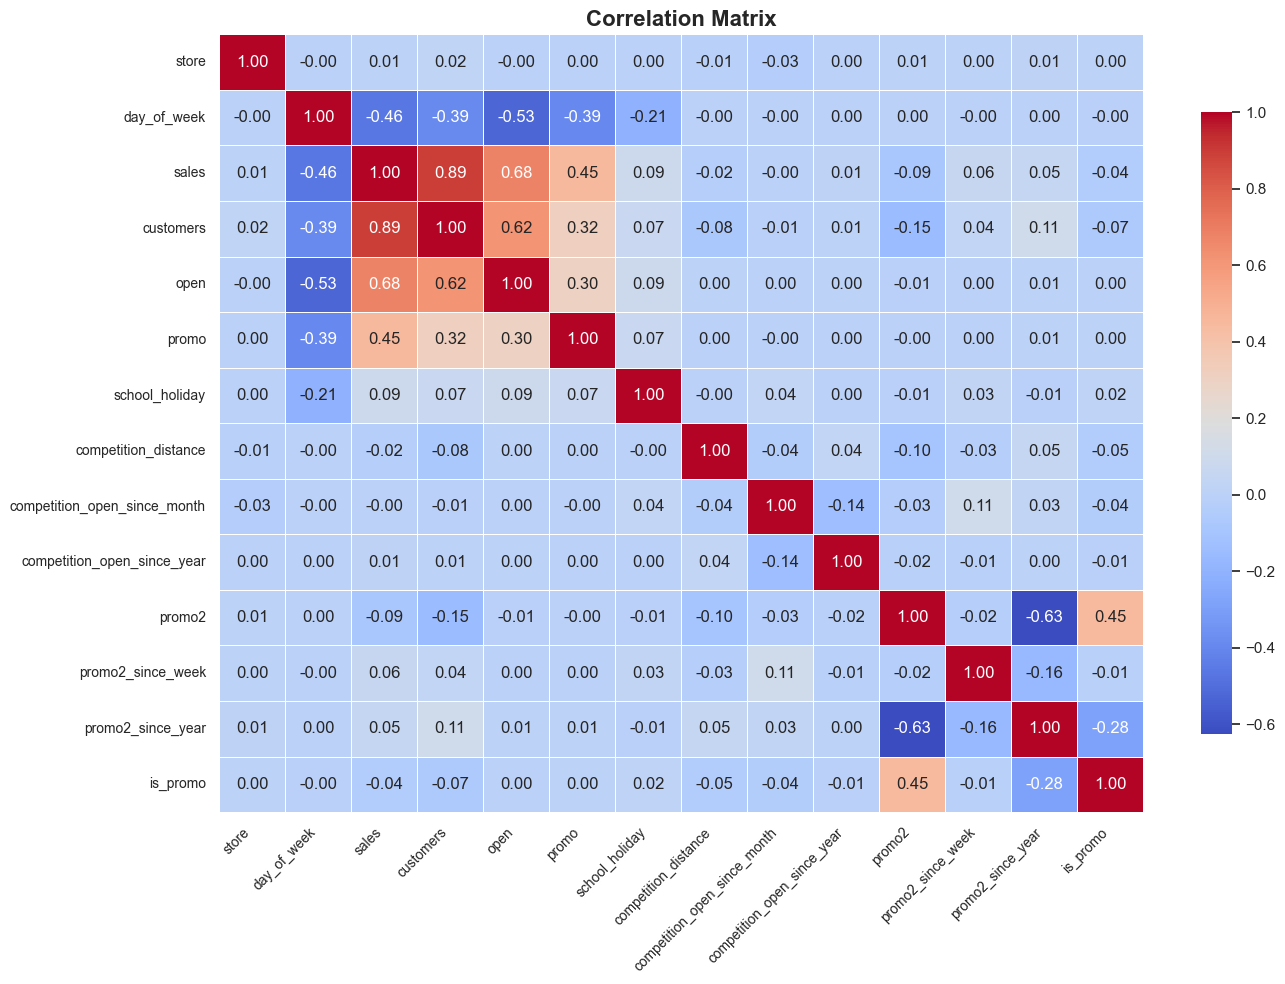

In [41]:
# Calculando a correlação
correlation = num_attributes.corr(method='pearson')

# Ajustando o tamanho da figura
plt.figure(figsize=(14, 10))  # Figura maior para acomodar os rótulos

# Criando o heatmap
sns.heatmap(
    correlation, 
    annot=True,           # Mostra os valores de correlação
    fmt=".2f",            # Formata os números com 2 casas decimais
    cmap="coolwarm",      # Esquema de cores
    cbar_kws={'shrink': 0.8}, # Reduz o tamanho da barra de cores
    linewidths=0.5        # Linhas entre os blocos do mapa
)

# Ajustando os rótulos do eixo X
plt.xticks(fontsize=10, rotation=45, ha='right')  # Rotaciona e alinha à direita
plt.yticks(fontsize=10)

# Título e layout
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### 4.3.2. Categorical Attributes

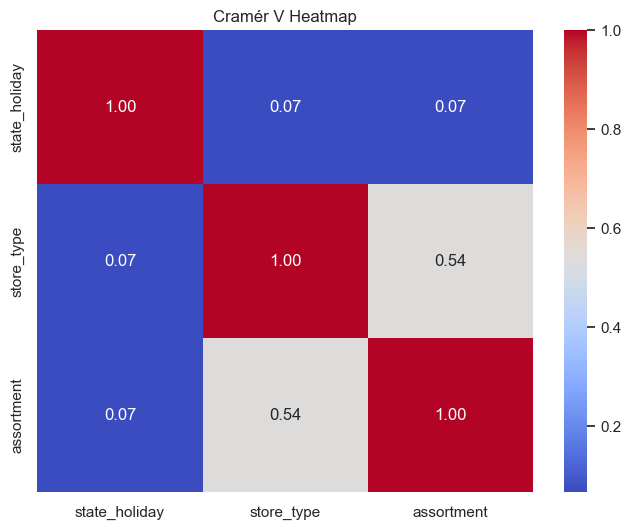

In [42]:
# Seleção de dados categóricos
a = df4.select_dtypes(include='object')

# Calcular Cramér V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])
a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])
a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Montar matriz final para heatmap
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]
}, index=['state_holiday', 'store_type', 'assortment'])

plt.figure(figsize=(8, 6))
sns.heatmap(d, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Cramér V Heatmap")
plt.show()

# 5.0. DATA PREPARATION

In [43]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [44]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )

# promo time week
# year
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3. Transformação

### 5.3.1. Encoding

In [45]:
# state_holiday- One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type- Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment- Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [46]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [47]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )

In [48]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. FEATURE SELECTION

In [49]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [50]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [51]:
# training dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [52]:
##training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


## 6.2.1. Best Features from Boruta

In [53]:
#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [52]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )